# Supplementary material: Propagator batch calibration

First create artificial returns from simple surrogate order-flow and the HDIM2 model. Then try to recover the kernels again and to predict the return using several different models.

In [1]:
# import external dependencies
# ----------------------------

# set the backend
import matplotlib
matplotlib.use('nbagg') # set plotting backend
import matplotlib.pyplot as plt
plt.ion()

# standard packages
import numpy as np
import pandas as pd

# included noise generator
from powerlaw_noise import powerlaw_psd_gaussian
# propagator models
import priceprop as prop
import priceprop.batch as pb
import spectral as spec

### Generate power-law correlated order-flow
Cross-correlations e.g. from returns to later signs are neglected. The purpose here is to demonstrate the model calibration and not to generate the most realistic order-flows possible.

In [2]:
# autocorrelation exponents
gamma_s = 0.5   # ... of the signs
gamma_c = 0.25  # ... of the price-change indicator
# time steps to simulate
steps = 10**5

In [28]:
# signs
s = np.sign(powerlaw_psd_gaussian(1-gamma_s, steps)).astype(int)
# change indicator
c = (powerlaw_psd_gaussian(1-gamma_c, steps) > 0)

In [29]:
# simulate HDIM2 model as "ground truth"
# ---------------------------------------------

# maximum lag for propagator kernel
lmax = 2**9
lags = np.arange(1,lmax+1)

# time steps
t = np.arange(steps, dtype=int)

# some power law kernels
## differential kernel
k_n = prop.k_pow(lmax+1, prop.beta_from_gamma(gamma_s))
k_c = prop.k_pow(lmax+1, prop.beta_from_gamma(gamma_s))

k_n[0] = 0
r = prop.hdim2(s, c, k_n, k_c)

Create a dataframe that resembles the way actual trading data may be analysed

In [30]:
# simulate split over different days
mean_day_length = 2**9
trades = pd.DataFrame({
    'r1':         r,  # one-step mid-return
    'sign':       s,  # signed volume (quantity) of a single trade
    'change':     c,  # change indicator
    # simulate days of different lenghts
    'date':       np.cumsum(np.random.rand(len(c)) / mean_day_length / 1.1).astype(int)
})
# split in two sample groups for out-of-sample analysis
trades['sample'] = trades['date'] % 2

In [31]:
trades.head()

,change,date,r1,sign,sample
0,False,0,0.0,1,0
1,False,0,-0.0,1,0
2,False,0,-0.0,1,0
3,False,0,-0.0,-1,0
4,False,0,-0.0,1,0


Now the trades are added to a dictionary which allows to collect also the price responses, correlation matrices, etc. for later analyses.

In [32]:
db = {'tt': trades, 'lmax': lmax} # tt stands for true trades, i.e. after merging transactions

### Calibrate and simulate the models

In [33]:
# this may take a few minutes
pb.calc_models(db, nfft='auto pad > %i'%lmax, group=True, calibrate=True, split_by='sample')

In [34]:
# A calibration dict 'cal' was added to db. 
# It includes one key for each of the sample groups (based on the column "samples" created above)
print "Calibration completed for the following sample groups:",
print db['cal'].keys()

Calibration completed for the following sample groups: [0, 1]


In [35]:
# the simulated time-series should now be included in the trades dataframe
db['tt'].tail(15)

,change,date,r1,sign,sample,sc,sn,r_cs,r_tim1,r_tim2,r_hdim2,r_hdim2_x2
99985,True,88,1.479425,1,0,1,0,1.0,0.742944,1.358767,1.480879,1.350821
99986,True,88,1.175617,1,0,1,0,1.0,0.589418,1.122906,1.177391,1.118817
99987,True,88,-0.974532,-1,0,-1,0,-1.0,-0.479718,-1.034536,-0.973182,-1.033539
99988,False,88,0.000000,-1,0,0,-1,-0.0,-0.369329,0.135344,0.000000,0.000000
99989,True,88,1.343002,1,0,1,0,1.0,0.674829,1.208323,1.355070,1.196925
99990,True,88,1.078734,1,0,1,0,1.0,0.544996,1.018367,1.086843,1.014031
99991,True,88,0.952513,1,0,1,0,1.0,0.474218,0.946593,0.957193,0.944339
99992,False,88,-0.000000,1,0,0,1,0.0,0.428741,-0.080612,-0.000000,-0.000000
99993,False,88,-0.000000,1,0,0,1,0.0,0.398093,-0.058065,-0.000000,-0.000000
99994,True,88,-1.227227,-1,0,-1,0,-1.0,-0.612098,-1.112869,-1.218366,-1.104622


### Plot fitted model kernels

<IPython.core.display.Javascript object>


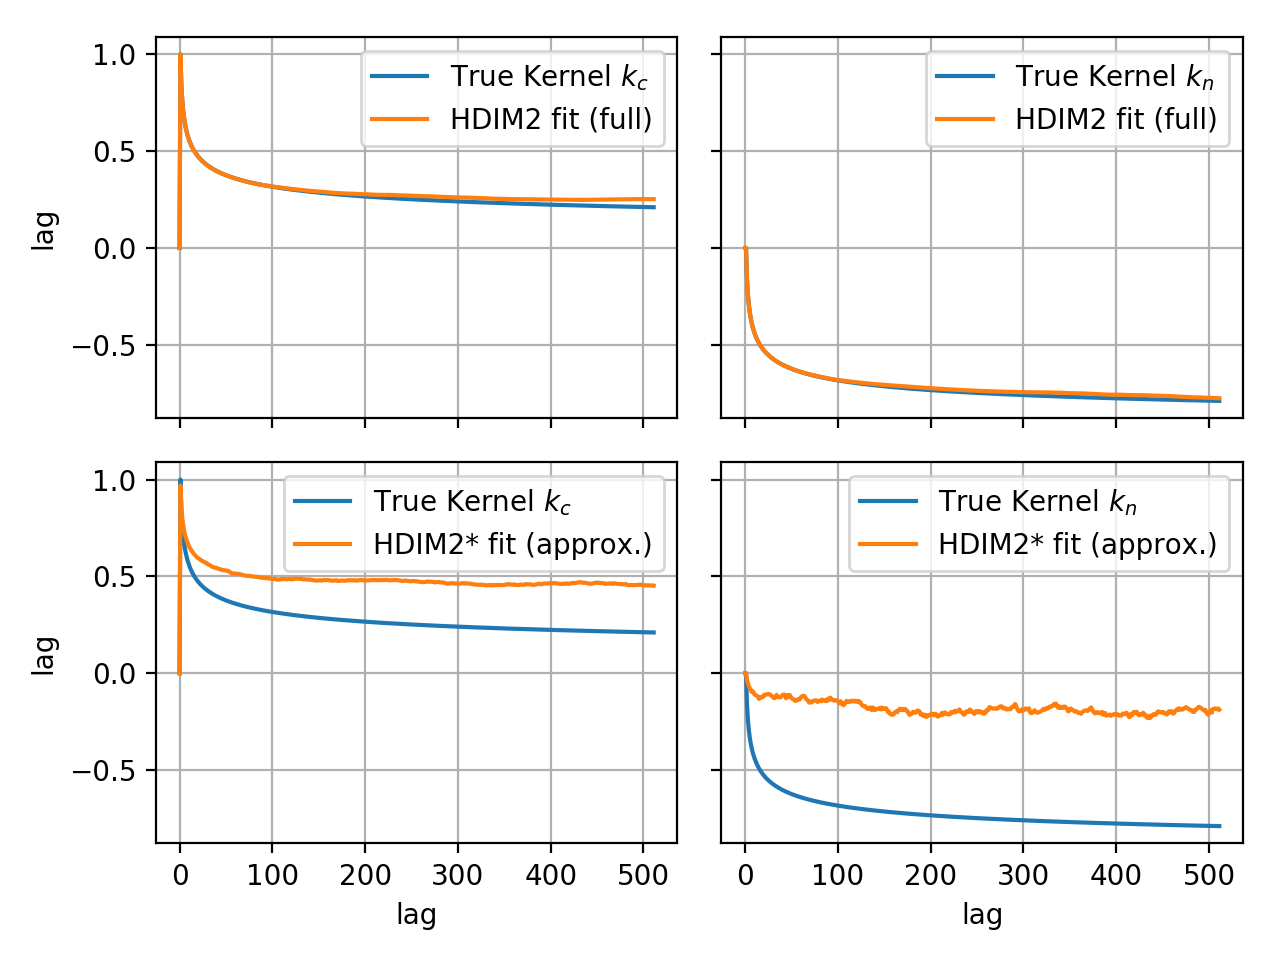

In [36]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

fn = prop.integrate # show integrated kernels

ax[0,0].plot(fn(k_c), label='True Kernel $k_c$')
ax[0,0].plot(fn(db['cal'][0]['kc']), label='HDIM2 fit (full)')
ax[0,0].legend()

ax[0,1].plot(fn(k_n), label='True Kernel $k_n$')
ax[0,1].plot(fn(db['cal'][0]['kn']), label='HDIM2 fit (full)')
ax[0,1].legend()


ax[1,0].plot(fn(k_c), label='True Kernel $k_c$')
ax[1,0].plot(fn(db['cal'][0]['kc_x2']), label='HDIM2* fit (approx.)')
ax[1,0].legend()

ax[1,1].plot(fn(k_n), label='True Kernel $k_n$')
ax[1,1].plot(fn(db['cal'][0]['kn_x2']), label='HDIM2* fit (approx.)')
ax[1,1].legend()

# optimise
for a in ax[:,0]:
    a.set_ylabel('lag')
for a in ax[-1,:]:
    a.set_xlabel('lag')
for a in ax.flatten():
    a.grid(True)

plt.tight_layout()

### Plot the original "true" returns and those predicted from the fitted models

<IPython.core.display.Javascript object>


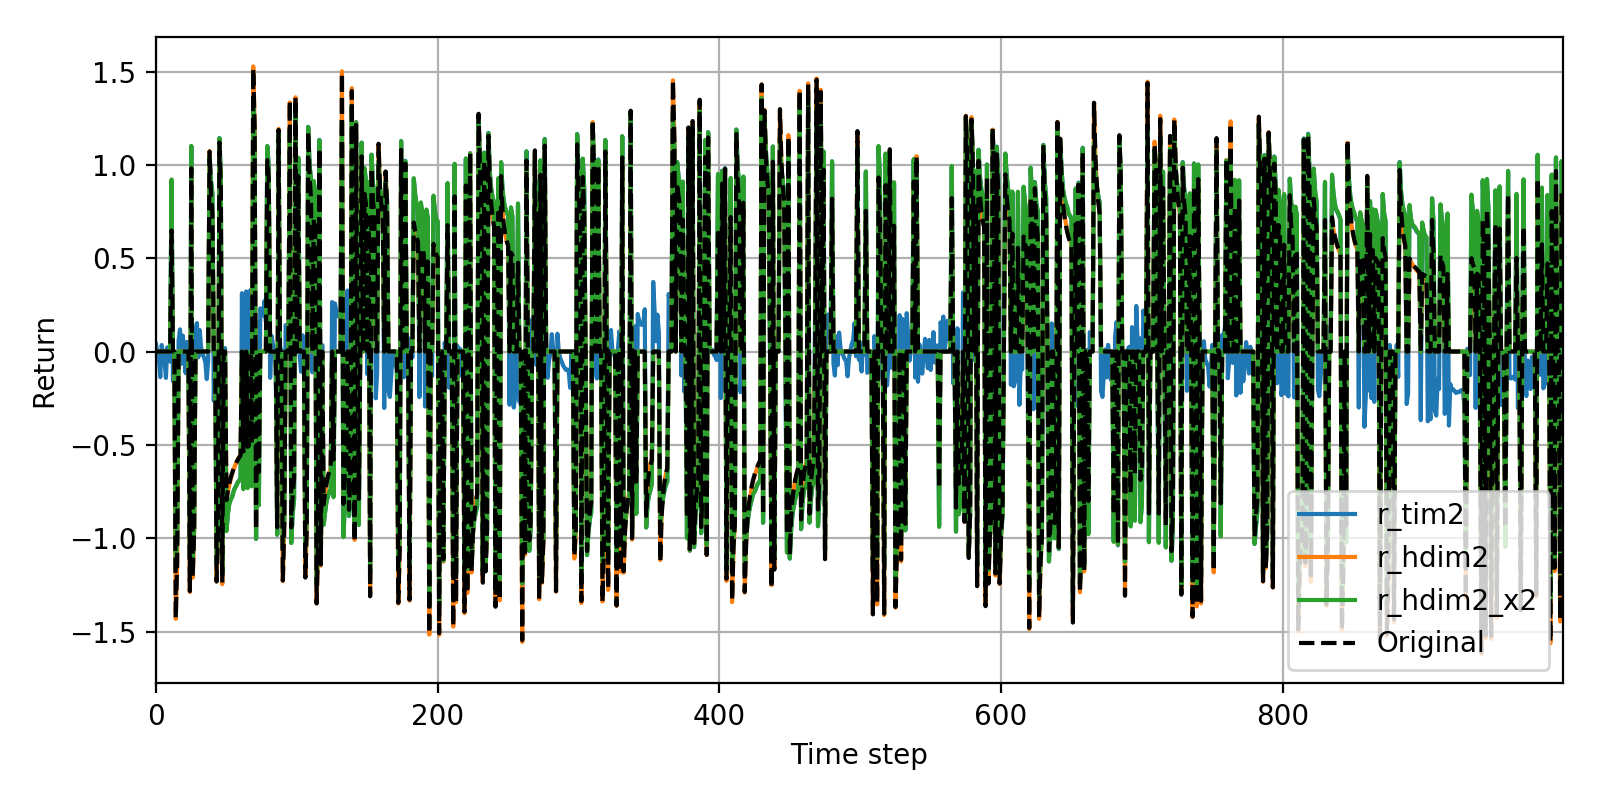

In [37]:
plt.figure(2, figsize=(8,4))
ax = plt.gca()

# choose a range between 0 and steps for the plot.
plot_start = 0
plot_end   = 1000
# plot the following predicted returns from these fitted models
# (un)comment lines to (de)select models
plot_models = [
    #'r_cim',
    #'r_tim1', 
    'r_tim2', 
    'r_hdim2',   # HDIM2 with full calibration
    'r_hdim2_x2' # HDIM2 with two-point approximation
]

# plot diverse models
predicted_returns = trades.iloc[plot_start:plot_end][plot_models]
predicted_returns.plot(ax=ax)

# original returns
original_returns = trades.iloc[plot_start:plot_end][['r1']]
original_returns.columns = ['Original']
original_returns.plot(style='k--', ax=ax)

# indicate date changes - there should be larger errors just at the beginning of a new day
plt.vlines(np.where(np.diff(trades['date'][plot_start:plot_end]))[0], -2,2, linestyles=':', colors='#999999')

# format
ax.set_xlabel('Time step')
ax.set_ylabel('Return')
plt.tight_layout()